# Chapter 5: Stratification and Post-Stratification in Randomized Experiments

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
# viz
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'IBM Plex Sans Condensed',
               'weight' : 'normal',
               'size'   : 10}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = (6, 6)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 1

%load_ext watermark
%watermark --iversions


matplotlib       : 3.6.3
matplotlib_inline: 0.1.6
scipy            : 1.10.0
statsmodels      : 0.13.5
numpy            : 1.23.5
pandas           : 1.5.2



In [2]:
penndata = pd.read_table('Penn46_ascii.txt', sep='\s+')
y, z, block = np.log(penndata.duration).values, penndata.treatment.values, penndata.quarter.values
penndata.head()


,duration,treatment,female,black,hispanic,ndependents,recall,young,old,quarter,durable,lusd
1,18.011343,0,0,0,0,2,0,0,0,5,0,0
4,1.003399,0,0,0,0,0,0,0,0,5,0,1
5,26.960396,0,0,0,0,0,0,0,0,4,0,1
6,7.009044,1,0,0,0,0,0,0,0,2,0,0
12,9.022409,1,0,0,0,0,0,1,0,3,0,0


In [3]:
pd.crosstab(z, block)


col_0,0,1,2,3,4,5
row_0,,,,,,
0,234,41,687,794,738,860
1,87,48,757,866,811,461


## FRT

In [4]:
def stat_SRE(z, y, x):
    xlevels = np.unique(x)
    K = len(xlevels)
    PiK, TauK, Wk = np.zeros(K), np.zeros(K), np.zeros(K)
    for k in range(K):
        id = np.where(x == xlevels[k])
        zk = z[id]
        yk = y[id]
        PiK[k] = zk.shape[0]/z.shape[0]
        TauK[k] = np.mean(yk[zk == 1]) - np.mean(yk[zk == 0])
        Wk[k] = sp.stats.mannwhitneyu(yk[zk == 1], yk[zk == 0])[0]
    return np.sum(PiK*TauK), sum(Wk/PiK)


def zRandomSRE(z, x):
    xlevels = np.unique(x)
    K = len(xlevels)
    zrandom = z.copy()
    for k in range(K):
        xk = xlevels[k]
        zrandom[x == xk] = np.random.permutation(z[x == xk])
    return zrandom


In [5]:
# observed test statistics
stat_obs = stat_SRE(z, y, block)
# null distribution
MC = int(1e3)
statSREMC = np.zeros((MC, 2))
for k in range(MC):
    zrandom = zRandomSRE(z, block)
    statSREMC[k] = stat_SRE(zrandom, y, block)

print(np.mean(statSREMC[:, 0] <= stat_obs[0]))
print(np.mean(statSREMC[:, 1] <= stat_obs[1]))


0.001
0.0


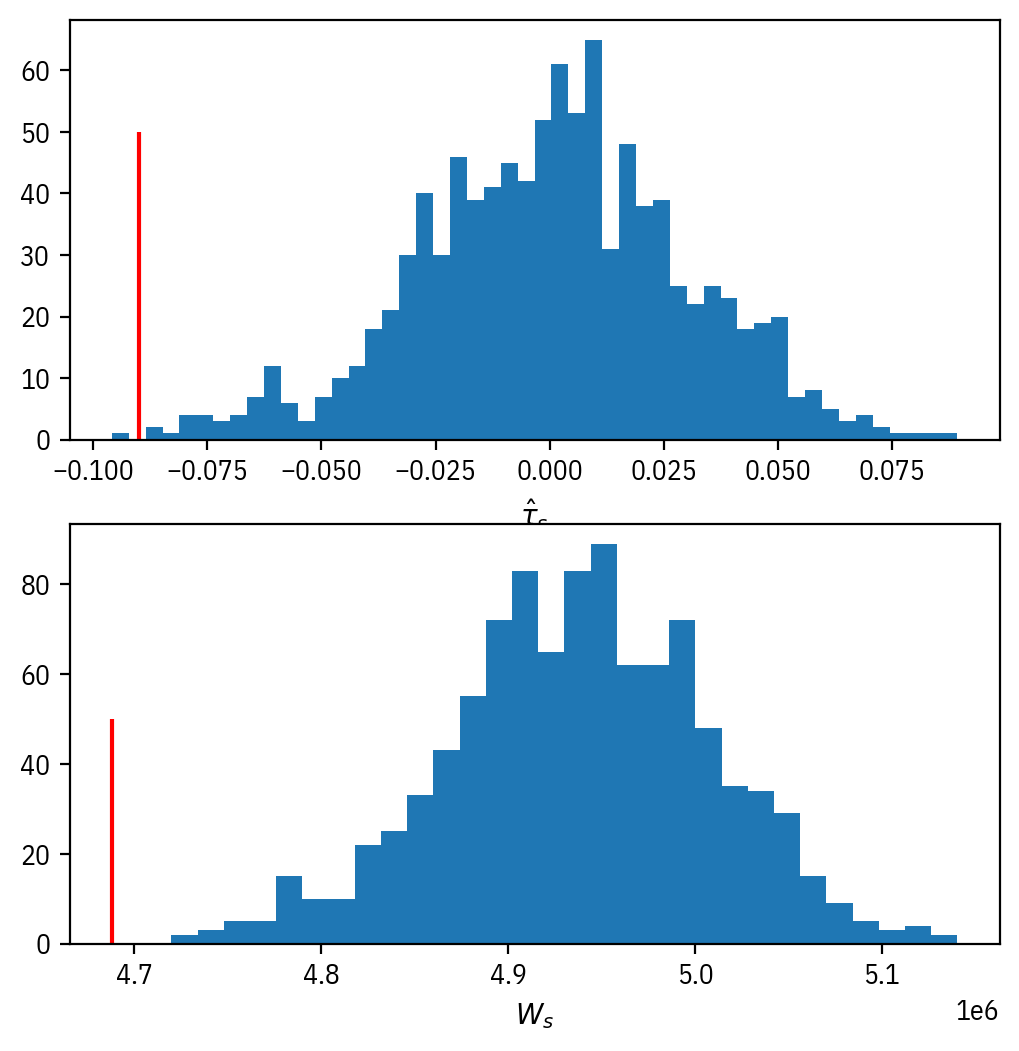

In [6]:
f, ax = plt.subplots(2, 1)
ax[0].hist(statSREMC[:, 0], bins = 50)
ax[0].vlines(stat_obs[0], 0, 50, color = 'red')
ax[0].set_xlabel(r"$\hat{\tau}_s$")
ax[1].hist(statSREMC[:, 1], bins = 30)
ax[1].vlines(stat_obs[1], 0, 50, color = 'red')
ax[1].set_xlabel(r"$W_s$")
plt.show()


## Neyman

In [7]:
def neyman_SRE(z, y, x):
    xlevels = np.unique(x)
    K = len(xlevels)
    PiK, TauK, varK = np.zeros(K), np.zeros(K), np.zeros(K)
    for k in range(K):
        id = np.where(x == xlevels[k])
        zk, yk = z[id], y[id]
        PiK[k] = zk.shape[0]/z.shape[0]
        TauK[k] = np.mean(yk[zk==1]) - np.mean(yk[zk==0])
        varK[k] = (np.var(yk[zk == 1], ddof = 1)/sum(zk) +
                   np.var(yk[zk == 0], ddof = 1)/sum(1-zk))
    return np.sum(PiK * TauK), np.sum(PiK**2 * varK)


In [8]:
def sim_cluster(K, n, n1, n0):
    x = np.repeat(range(K), n)
    y0 = np.random.exponential(1, n*K)
    y1 = y0 + 1
    # block level assignment vector
    zb = np.repeat([0, 1], [n0, n1])
    MC = int(1e4)
    TauHat, VarHat = np.zeros(MC), np.zeros(MC)
    for k in range(MC):
        z = np.concatenate([np.random.permutation(zb) for i in range(K)])
        y = z * y1 + (1 - z) * y0
        TauHat[k], VarHat[k] = neyman_SRE(z, y, x)
    plt.hist(TauHat, bins = 50)
    plt.vlines(1, 0, 500, color = 'red')
    return np.var(TauHat), np.mean(VarHat)


(0.009246682951149512, 0.009240918913991265)

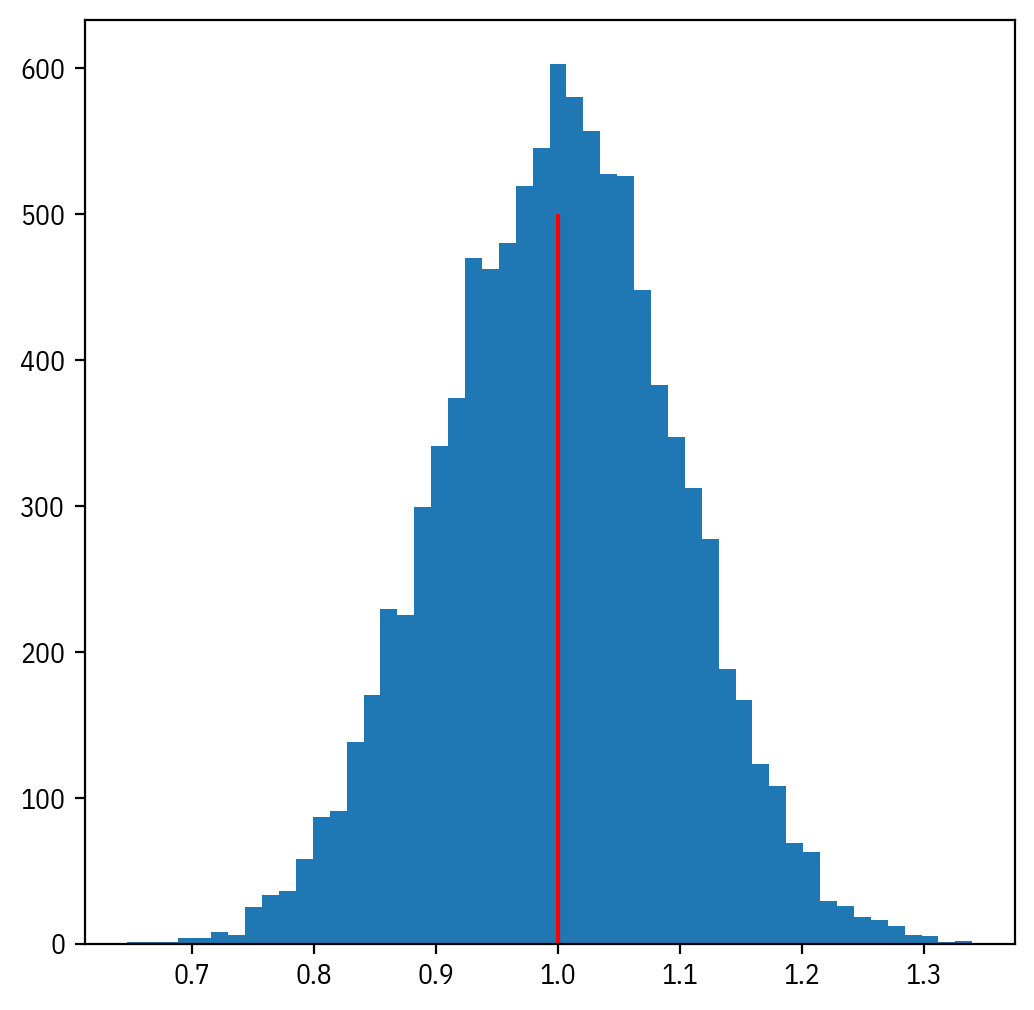

In [9]:
sim_cluster(5, 80, 50, 30)


(0.01321369399961591, 0.013221299244967634)

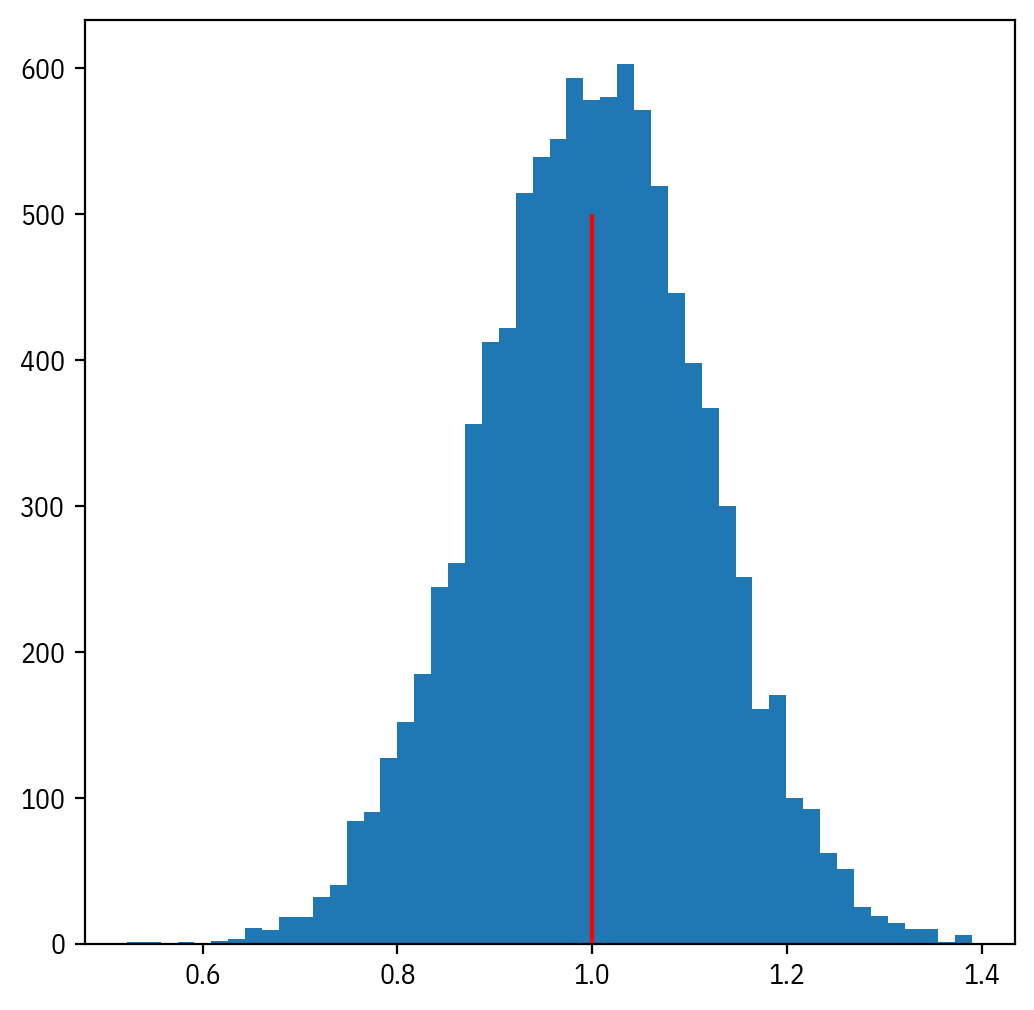

In [10]:
sim_cluster(50, 8, 5, 3)


### application to Penn bonus experiment

In [11]:
est, var = neyman_SRE(z, y, block)
est, np.sqrt(var)


(-0.0899064590011073, 0.030797749686469634)

## chong et al (2016)

In [12]:
dat_chong = pd.read_stata('chong.dta')
pd.crosstab(dat_chong.treatment, dat_chong.class_level)


class_level,1.0,2.0,3.0,4.0,5.0
treatment,,,,,
Soccer Player,16,19,15,10,10
Physician,17,20,15,11,10
Placebo,15,19,16,12,10


In [13]:
use_vars = ['treatment', 'gradesq34', 'class_level', 'anemic_base_re']
dat_physician = dat_chong.loc[dat_chong.treatment != "Soccer Player", use_vars]
dat_physician['z'] = np.where(dat_physician.treatment == "Physician", 1, 0)
dat_physician['y'] = dat_physician.gradesq34
pd.crosstab(dat_physician.z, dat_physician.class_level)


class_level,1.0,2.0,3.0,4.0,5.0
z,,,,,
0,15,19,16,12,10
1,17,20,15,11,10


In [14]:
(tauS := neyman_SRE(dat_physician.z.values, dat_physician.y.values, dat_physician.class_level.values))


(0.40589046478271484, 0.04096197815071462)

In [15]:
dat_physician['sps'] = (pd.Categorical(dat_physician['class_level'].astype(str) +
                            '_' + dat_physician['anemic_base_re'].astype(str)))
(tauSPS := neyman_SRE(dat_physician.z.values, dat_physician.y.values, dat_physician.sps.values))


(0.4633431335975384, 0.03624964630443229)

In [16]:
seS = np.sqrt(tauS[1])
seSPS  = np.sqrt(tauSPS[1])

pvalS = 2 * (1 - sp.stats.norm.cdf(abs(tauS[0] / seS)))
pvalSPS = 2 * (1 - sp.stats.norm.cdf(abs(tauSPS[0] / seSPS)))

pd.DataFrame(
    np.r_[np.c_[tauS[0], seS, tauS[0]/seS, pvalS],
          np.c_[tauSPS[0], seSPS, tauSPS[0]/seSPS, pvalSPS]],
    columns = ['Estimate', 'Std. Error', 'z value', 'Pr(>|z|)'],
    index = ['Stratify', 'Stratify and post-stratify'])


,Estimate,Std. Error,z value,Pr(>|z|)
Stratify,0.405890,0.202391,2.005480,0.044912
Stratify and post-stratify,0.463343,0.190393,2.433609,0.014949
